In [1]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm

from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter

In [2]:
def compute_H(J, num_sites):
    H = 0
    for i in range(num_sites - 1):
        H += J * ((I ^ (num_sites - i - 2)) ^ (Z ^ Z) ^ (I ^ i))
    return H


# Example computation. This Hamiltonian is the same model we cover in the paper and will persist through the notebook.
num_sites = 3

# Parameterized hopping strengths
J = Parameter("J")
H_param = compute_H(J, num_sites)

# Select specific tau and tau_d values
H = H_param.bind_parameters({J: 1})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliOp(Pauli('IZZ'), coeff=1.0), PauliOp(Pauli('ZZI'), coeff=1.0)], coeff=1.0, abelian=False)

In [7]:
def compute_U(H, t):
    U = (H * t).exp_i()
    return U

# Define a list of number operators in terms of Pauli operators
z_is = [
    ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1)))
    for i in range(num_sites)
]

def exact_time_evolution(H,obseravble, initial_state, times, num_sites):
    evo_matrix = np.zeros((len(times), num_sites))
    var_matrix = np.zeros(len(times))
    for i, time in enumerate(tqdm(times)):
        for j, oi in enumerate(obseravble):
            # Compute the time evolution operator U(time) at time time
            U = compute_U(H, time)
            # Compute the evolution of the initial state
            final_state = U @ initial_state
            # Compute the expectation value n_i
            evo_matrix[i, j] = np.abs((final_state.adjoint() @ oi @ final_state).eval())
        var_matrix[i] = (
            np.abs((final_state.adjoint() @ (sum(obseravble) @ sum(obseravble)) @ final_state).eval())
            - np.abs((final_state.adjoint() @ sum(obseravble) @ final_state).eval()) ** 2
        )
    return evo_matrix, var_matrix
# Plot the time evolution
times = np.linspace(0, 4 * np.pi, 500)
initial_state_1 = Zero ^ Zero ^ Zero #1/np.sqrt(3) * (Zero ^ Zero ^ Zero) + 1/np.sqrt(3) * (One ^ One ^ One)
initial_state_2 = 1/np.sqrt(3) * (Zero ^ Zero ^ Zero) + 1/np.sqrt(3) * (One ^ One ^ One)
H_1 = H_param.bind_parameters({J: -1})   

n_J05_evo_matrix, n_var_matrix = exact_time_evolution(H, z_is, initial_state_1, times, num_sites)
n_J1_evo_matrix, n_var_matrix = exact_time_evolution(H, z_is, initial_state_2, times, num_sites)

100%|██████████| 500/500 [00:06<00:00, 77.48it/s]


/tmp/ipykernel_1389/643387581.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(['0','3','6'])


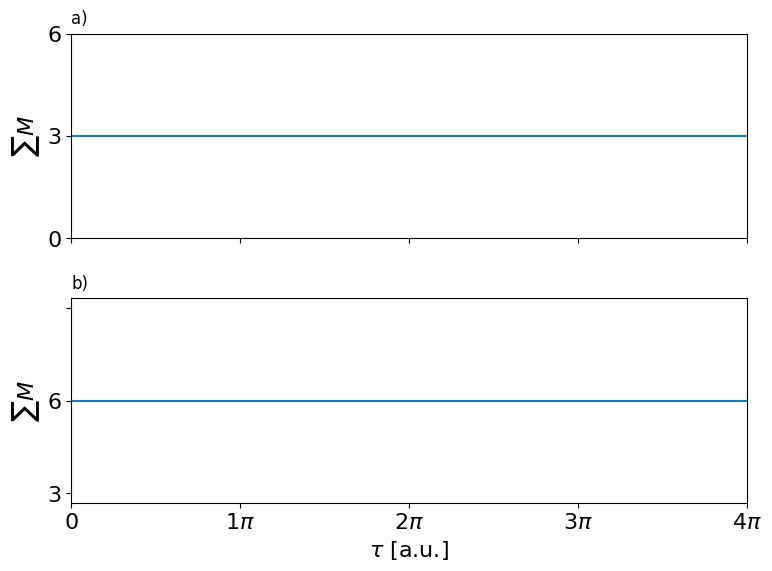

In [9]:
# Define xticks and labels
xticks = np.linspace(0, 4*np.pi, 5)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(5)]

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# First plot (a)
axes[0].plot(times, np.sum(n_J05_evo_matrix, axis=1))
axes[0].set_ylabel(rf"$\sum M$")
axes[0].set_ylim([0, 3])
axes[0].set_yticks([0, 3, 6])
axes[0].set_yticklabels(['0','3','6'])
axes[0].text(0, 1.05, 'a)', transform=axes[0].transAxes, fontsize=12)

# Second plot (b)
axes[1].plot(times, np.sum(n_J1_evo_matrix, axis=1))
axes[1].set_xlabel(rf"$\tau$ [a.u.]")
axes[1].set_ylabel(rf"$\sum M$")
#axes[1].set_ylim([0, 3])
#axes[1].set_yticks([0, 3, 6])
axes[1].set_yticklabels(['0','3','6'])
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xtick_labels)
axes[1].text(0, 1.05, 'b)', transform=axes[1].transAxes, fontsize=12)

# Final adjustments
plt.xlim([0, 4*np.pi])
plt.tight_layout()
plt.savefig("figures/ising/magnetization-comparison.pdf")
plt.show()


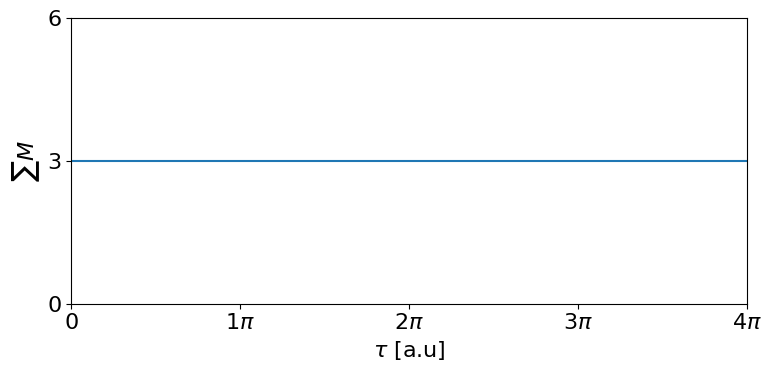

In [14]:
#num_op_labels = [r"$\langle n_" + str(i+1) + "\\rangle$" for i in range(num_sites)]
xticks = np.linspace(0, 4*np.pi, 5)
xtick_labels = [r'${}\pi$'.format(i) if i != 0 else '0' for i in range(5)]

plt.figure(figsize=(8, 4))
plt.plot(times, np.sum(n_J1_evo_matrix, axis=1))
plt.xlabel(rf"$\tau$ [a.u]")
plt.ylabel(rf"$\sum M$")
plt.title("")
plt.ylim([0, 3])
plt.xlim([0,4*np.pi])
plt.yticks([0, 3, 6], ['0','3', '6'])
plt.xticks(xticks, xtick_labels)

plt.tight_layout()
plt.savefig("figures/ising/J=1-magnetization-Z.pdf")
plt.show()

### Draw circuit

In [ ]:
from qiskit.opflow import PauliTrotterEvolution

def convert_U_trot_to_qc(U_trot):

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose().decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks
    
U1 = compute_U_trot(H_2, np.pi, 1)
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/2-site-circuit.tex", "w") as f:
    f.write(latex_code)

NameError: name 'compute_U_trot' is not defined